# Data exploration
Halo reports from four Minneapolis public schools: Camden (Henry in the dataset), Anwatin, Anderson, and Roosevelt

## Cleaning

In [60]:
import pandas as pd
from datetime import datetime

csv_files = ['halo-report-data-csv/haloreport-2024-09-02-2024-12-02-copy.csv', 'halo-report-data-csv/haloreport-2024-12-03-2025-02-03-copy.csv',
            'halo-report-data-csv/haloreport-2025-02-03-2025-03-03-copy.csv', 'halo-report-data-csv/haloreport-2025-03-04-2025-04-15-copy.csv']
df = pd.DataFrame()

for file in csv_files:
    x = pd.read_csv(file)
    print(f'File has {x.shape[0]} rows')
    x['Date'] = pd.to_datetime(x['Date'], format='%m/%d/%Y')
    df = pd.concat([df, x], ignore_index=True)

print(f'Combined file has {df.shape[0]} rows')

File has 30277 rows
File has 777 rows
File has 5730 rows
File has 9040 rows
Combined file has 45824 rows


In [61]:
df.head()

,Site,Device,MAC,Type,Date,Start Time,Stop Time,Timestamp,Value
0,Site 1,Andersen_1st_Floor_B130_All_Gender,B0-B3-53-D1-76-BE,Vape,2024-11-02,7:09:39 AM,7:10:19 AM,1730549379,126.16
1,Site 1,Andersen_1st_Floor_B130_All_Gender,B0-B3-53-D1-76-BE,Vape,2024-11-02,7:11:41 AM,7:12:11 AM,1730549501,64.52
2,Site 1,Andersen_1st_Floor_B130_All_Gender,B0-B3-53-D1-76-BE,Vape,2024-11-02,7:39:22 AM,7:39:52 AM,1730551162,40.88
3,Site 1,Andersen_1st_Floor_B130_All_Gender,B0-B3-53-D1-76-BE,Vape,2024-11-02,9:58:32 AM,9:59:02 AM,1730559512,49.40
4,Site 1,Andersen_1st_Floor_B130_All_Gender,B0-B3-53-D1-76-BE,Vape,2024-11-02,9:59:28 AM,9:59:58 AM,1730559568,54.58


In [62]:
# Transform the dataset
df['School'] = df['Device'].apply(lambda x: x.split('_')[0])
df['Site'] = df['Device'].apply(lambda x: ' '.join(x.split('_')[1:]))
# Combine 'Date' with 'Start Time' and 'Stop Time'
df['Start Time'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Start Time'], format='%Y-%m-%d %I:%M:%S %p')
df['Stop Time'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Stop Time'], format='%Y-%m-%d %I:%M:%S %p')
df['Duration'] = (df['Stop Time'] - df['Start Time']).dt.total_seconds()

In [63]:
#df.to_csv('halo-report-data-csv/cleaned_halo_data.csv', index=False)

In [64]:
df.Device.unique()

array(['Andersen_1st_Floor_B130_All_Gender',
       'Andersen_2nd__Floor__C226_All_Gender',
       'Andersen_2nd_Floor_B226_All_Gender',
       'Andersen_2nd_Floor_Boys_D223_SE_Round',
       'Andersen_2nd_Floor_D201_Boys_SW_Round',
       'Andersen_2nd_Floor_D202_Girls_SW_Round',
       'Andersen_2nd_Floor_Girls_D221_SE_Round', 'Anwatin_Boys_407_#1',
       'Anwatin_Boys_407_#2', 'Anwatin_Girls_209_#1',
       'Anwatin_Girls_209_#2', 'Anwatin_Girls_418_#1',
       'Anwatin_Girls_418_#2',
       'Henry_1st_floor_stair_1_NW_Boys_restrooms',
       'Henry_1st_Floor_Stair_12_NE_Girls_Restrooms',
       'Henry_2nd_Floor_Stair_1_NW_Restroom_#3',
       'Henry_2nd_Floor_Stair_12_NE_Restrooms_#1',
       'Henry_2nd_Floor_Stair_14_SW_Restrooms_#1',
       'Henry_3RD_Floor_Stair_1_NW_Restroom_#1',
       'Henry_3rd_Floor_Stair_12_NE_Restrooms_#1',
       'Henry_3rd_Floor_Stair_14_SW_Restroom_#1',
       'Roosevelt_1st_floor_144_North_Sensor',
       'Roosevelt_1st_floor_144_South__Sensor',
    

## Exploratory analysis

Discoveries:
1. Each detected event usually lasts for around 30 to 40 seconds; multiple detected events may all refer to the same actual event (e.g., if a student smokes for 2 minutes, it'll show up as 4 detected events.) -> Suggestion: merge detected events that are 30 seconds apart from each other as the same actual event.

2. The relationship between the behavior type report and the halo report dataset remain unclear. Some disciplinary incident seems not to be based on detected events (e.g., teacher spotting vape falling out of a student's pocket.) Furthermore, many detected events seemed not to lead to any disciplinary incidents.

In [65]:
# Read the csv and segment the dataset
df = pd.read_csv('halo-report-data-csv/cleaned_halo_data.csv')
andersen_df = df[df['School'] == 'Andersen']
anwatin_df = df[df['School'] == 'Anwatin']
camden_df = df[df['School'] == 'Henry']
roosevelt_df = df[df['School'] == 'Roosevelt']

In [66]:
# Get some basic stats by school
alert_count = df.School.value_counts()
device_count = df.groupby(by='School').Device.nunique()
meta = pd.DataFrame({'alert_count': alert_count, 'device_count': device_count})
meta

,alert_count,device_count
School,,
Andersen,2107,8
Anwatin,786,7
Henry,21415,8
Roosevelt,21516,6


### General functions

In [67]:
# Graph: Alert count by day (option: type)
import seaborn as sns
import matplotlib.pyplot as plt

def alert_count_by_day(df, type=None, save_path=None):
    # Group by 'Date' and the specified 'group', then count occurrences
    if type:
        date_count = df[df['Type'] == type].Date.value_counts(sort=False).sort_index()
    else:
        date_count = df.Date.value_counts(sort=False).sort_index()

    plt.figure(figsize=(18, 6))
    sns.barplot(x=date_count.index, y=date_count.values)
    if type:
        plt.title(f'{df.School.unique()[0]} {type} Alert Count by Day', fontsize=16)
    else:
        plt.title(f'{df.School.unique()[0]} Alert Count by Day', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Alert Count', fontsize=14)
    plt.xticks(rotation=90)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

In [68]:
# Graph: grouped alert count by day
import seaborn as sns
import matplotlib.pyplot as plt

def grouped_alert_count_by_day(df, group, save_path=None):
    # Group by 'Date' and the specified 'group', then count occurrences
    date_counts = df.groupby(['Date', group]).size().reset_index(name='count').sort_index()
    
    plt.figure(figsize=(18, 6))
    sns.barplot(x='Date', y='count', hue=group, data=date_counts, palette='Set2')
    plt.legend()

    plt.title(f'{df.School.unique()[0]} Grouped Alert Count by Day', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Alert Count', fontsize=14)
    plt.xticks(rotation=90)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

In [69]:
# Stats: alert count by month / average alert count by day per month
def alert_count_by_month(df, type=None):
    # Group by 'Date' and the specified 'group', then count occurrences
    if type:
        date_count = df[df['Type'] == type].Date.value_counts(sort=False).sort_index()
    else:
        date_count = df.Date.value_counts(sort=False).sort_index()

    # Convert the index to datetime
    date_count.index = pd.to_datetime(date_count.index)

    # Resample to monthly frequency and sum the counts
    monthly_counts = date_count.resample('M').sum()

    # Calculate the average alert count per day for each month
    avg_alerts_per_day = monthly_counts / monthly_counts.index.days_in_month

    return monthly_counts, avg_alerts_per_day


In [73]:
# Graph: Monthly alert counts and average daily alerts
import matplotlib.pyplot as plt
import pandas as pd

def plot_monthly_data(df, school_name):
    """
    Plots monthly alert counts and average daily alerts on a dual-axis chart.

    Args:
        df (pd.DataFrame): DataFrame containing 'monthly_counts' and 'avg_alerts_per_day' columns.
        school_name (str): Name of the school for the chart title.
    """

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Plot monthly counts on the primary y-axis
    color = 'tab:blue'
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Monthly Alert Counts', color=color)
    ax1.bar(df.index, df['monthly_counts'], color=color, alpha=0.7, label='Monthly Alerts')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', rotation=45)

    # Create a secondary y-axis
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Avg. Daily Alerts', color=color)
    ax2.plot(df.index, df['avg_alerts_per_day'], color=color, marker='o', label='Avg. Daily Alerts')
    ax2.tick_params(axis='y', labelcolor=color)

    # Add title and legend
    plt.title(f'{school_name} - Monthly Alerts and Avg. Daily Alerts', fontsize=16)
    fig.tight_layout()

    # Combine legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.show()

### Andersen Middle
1098 Andersen Lane, Minneapolis MN 55407

1. First alert: Sep 11, 2024 ; Last event: Apr 16, 2025

2. 

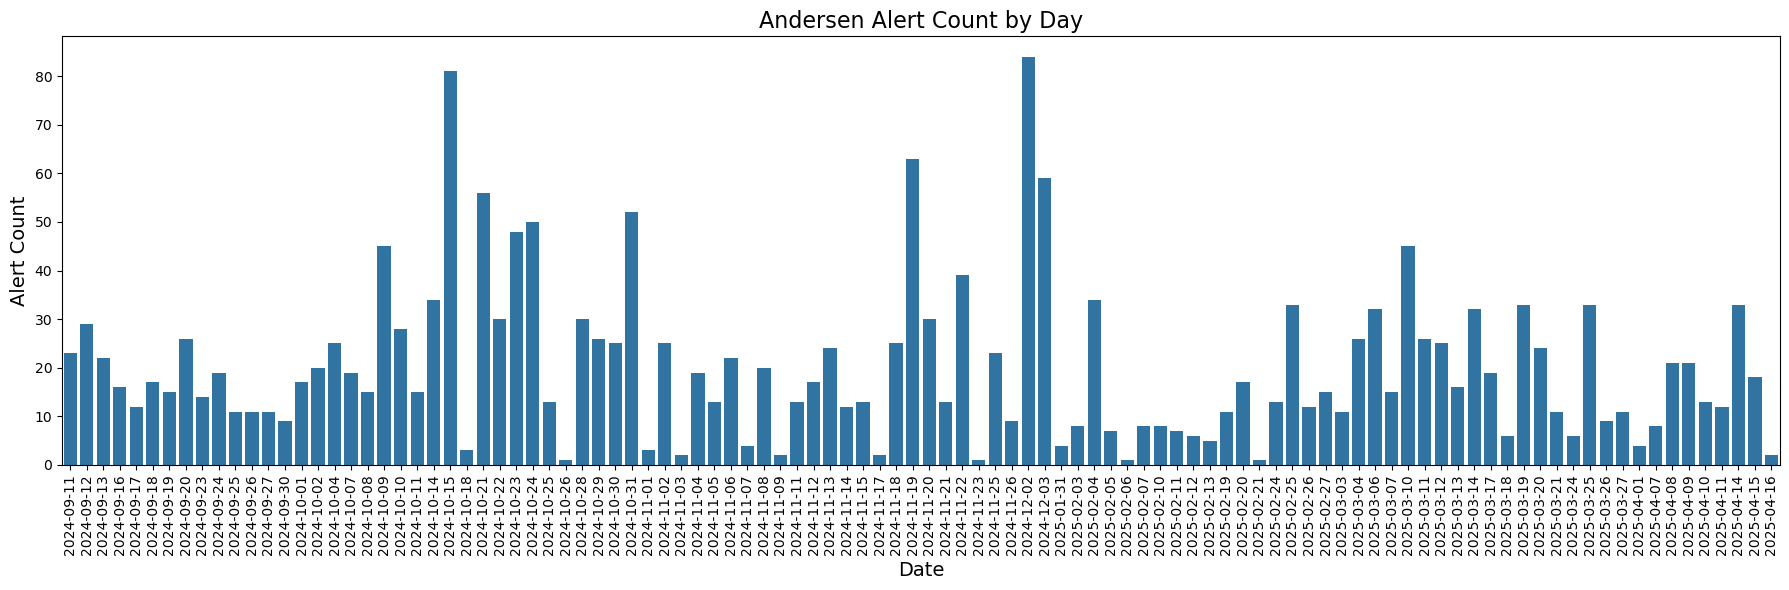

In [70]:
alert_count_by_day(andersen_df)

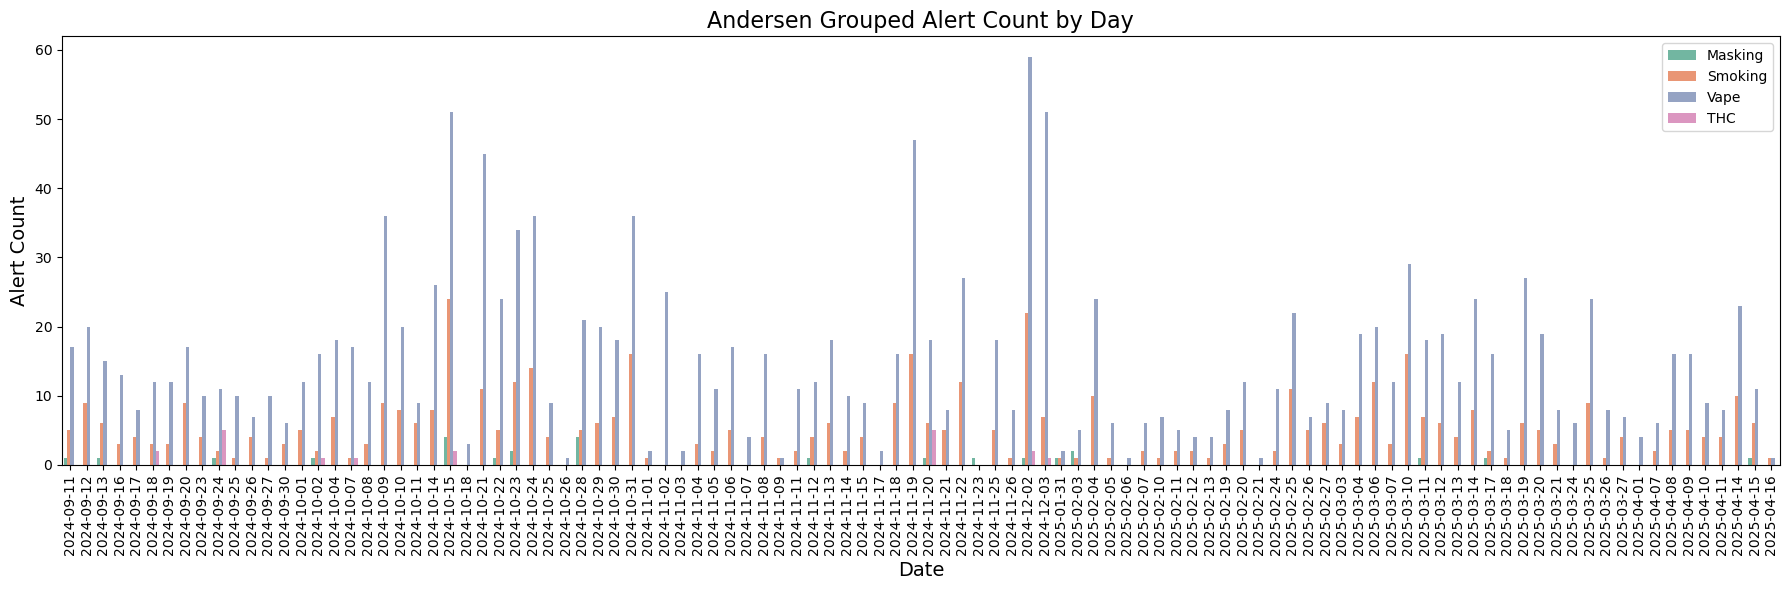

In [71]:
grouped_alert_count_by_day(andersen_df, 'Type')

In [72]:
# Calculate the per month average of alerts
andersen_monthly_counts, andersen_monthly_dayavg = alert_count_by_month(andersen_df)
andersen_monthly = pd.DataFrame({'monthly_counts': andersen_monthly_counts, 'avg_alerts_per_day': andersen_monthly_dayavg})
andersen_monthly.index = andersen_monthly.index.strftime('%Y-%m')
andersen_monthly

/var/folders/yt/xv1c41h15flg31_2xgl1rnj00000gn/T/ipykernel_34867/955996457.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = date_count.resample('M').sum()


,monthly_counts,avg_alerts_per_day
Date,,
2024-09,235,7.833333
2024-10,633,20.419355
2024-11,394,13.133333
2024-12,143,4.612903
2025-01,4,0.129032
2025-02,186,6.642857
2025-03,380,12.258065
2025-04,132,4.400000


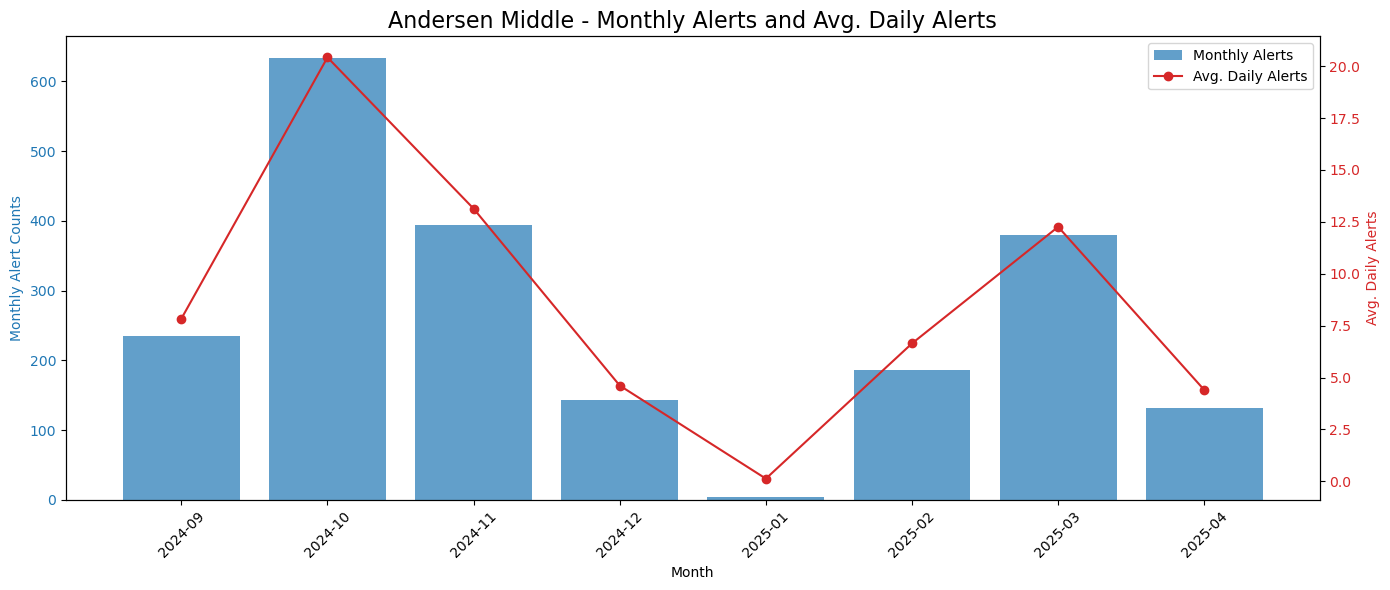

In [74]:
# Graph andersen_monthly
plot_monthly_data(andersen_monthly, 'Andersen Middle')

According to the behavior type report, Andersen Middle saw 14 events of vaping (with 16 students caught).
The events happened on (mm/dd/YY):
- 04/08/25
- 03/03/25
- 02/13/25 (same event with two students)
- 02/07/25 (same event with one student, seemed to be double counted)
- 12/17/24 (same event with one student, seemed to be double counted)
- 11/07/24
- 10/28/24
- 10/23/24
- 10/22/24
- 09/10/24 (same event but two students)
- 09/09/24
- 09/03/24


In [13]:
andersen_df[andersen_df['Date'] == '2025-02-13'].sort_values(by='Start Time', ascending=False)

,Site,Device,MAC,Type,Date,Start Time,Stop Time,Timestamp,Value,School,Duration
31070,2nd Floor Boys D223 SE Round,Andersen_2nd_Floor_Boys_D223_SE_Round,B0-B3-53-D1-29-53,Smoking,2025-02-13,2025-02-13 15:12:57,2025-02-13 15:13:27,1739481177,-110.44,Andersen,30.0
31069,2nd Floor Boys D223 SE Round,Andersen_2nd_Floor_Boys_D223_SE_Round,B0-B3-53-D1-29-53,Vape,2025-02-13,2025-02-13 15:12:32,2025-02-13 15:13:02,1739481152,831.15,Andersen,30.0
31152,2nd Floor D201 Boys SW Round,Andersen_2nd_Floor_D201_Boys_SW_Round,B0-B3-53-D1-76-1D,Vape,2025-02-13,2025-02-13 13:04:55,2025-02-13 13:05:25,1739473495,101.42,Andersen,30.0
31151,2nd Floor D201 Boys SW Round,Andersen_2nd_Floor_D201_Boys_SW_Round,B0-B3-53-D1-76-1D,Vape,2025-02-13,2025-02-13 10:04:35,2025-02-13 10:05:05,1739462675,54.00,Andersen,30.0
31150,2nd Floor D201 Boys SW Round,Andersen_2nd_Floor_D201_Boys_SW_Round,B0-B3-53-D1-76-1D,Vape,2025-02-13,2025-02-13 10:03:08,2025-02-13 10:03:38,1739462588,246.13,Andersen,30.0


In [14]:
andersen_df[andersen_df['Type'] == 'Masking'].Date.unique()

array(['2024-09-13', '2024-10-23', '2024-10-28', '2024-11-12',
       '2024-10-02', '2024-11-20', '2024-11-23', '2024-09-24',
       '2024-10-15', '2024-09-11', '2024-10-22', '2024-12-02',
       '2025-01-31', '2025-02-03', '2025-04-15', '2025-03-11',
       '2025-03-17'], dtype=object)

In [15]:
andersen_df[andersen_df['Date']=='2024-10-23'].sort_values(by='Start Time', ascending=False)

,Site,Device,MAC,Type,Date,Start Time,Stop Time,Timestamp,Value,School,Duration
155,2nd Floor C226 All Gender,Andersen_2nd__Floor__C226_All_Gender,B0-B3-53-D1-76-26,Vape,2024-10-23,2024-10-23 20:29:35,2024-10-23 20:30:05,1729733375,76.28,Andersen,30.0
1255,2nd Floor Girls D221 SE Round,Andersen_2nd_Floor_Girls_D221_SE_Round,B0-B3-53-D1-76-8F,Vape,2024-10-23,2024-10-23 16:52:37,2024-10-23 16:53:07,1729720357,50.08,Andersen,30.0
1254,2nd Floor Girls D221 SE Round,Andersen_2nd_Floor_Girls_D221_SE_Round,B0-B3-53-D1-76-8F,Smoking,2024-10-23,2024-10-23 16:46:56,2024-10-23 16:47:26,1729720016,18.72,Andersen,30.0
1253,2nd Floor Girls D221 SE Round,Andersen_2nd_Floor_Girls_D221_SE_Round,B0-B3-53-D1-76-8F,Vape,2024-10-23,2024-10-23 16:46:31,2024-10-23 16:47:01,1729719991,975.66,Andersen,30.0
460,2nd Floor Boys D223 SE Round,Andersen_2nd_Floor_Boys_D223_SE_Round,B0-B3-53-D1-29-53,Vape,2024-10-23,2024-10-23 15:22:51,2024-10-23 15:23:21,1729714971,103.46,Andersen,30.0
459,2nd Floor Boys D223 SE Round,Andersen_2nd_Floor_Boys_D223_SE_Round,B0-B3-53-D1-29-53,Vape,2024-10-23,2024-10-23 15:20:48,2024-10-23 15:21:18,1729714848,112.84,Andersen,30.0
458,2nd Floor Boys D223 SE Round,Andersen_2nd_Floor_Boys_D223_SE_Round,B0-B3-53-D1-29-53,Smoking,2024-10-23,2024-10-23 15:20:07,2024-10-23 15:20:37,1729714807,-79.64,Andersen,30.0
457,2nd Floor Boys D223 SE Round,Andersen_2nd_Floor_Boys_D223_SE_Round,B0-B3-53-D1-29-53,Vape,2024-10-23,2024-10-23 15:19:42,2024-10-23 15:20:12,1729714782,226.30,Andersen,30.0
456,2nd Floor Boys D223 SE Round,Andersen_2nd_Floor_Boys_D223_SE_Round,B0-B3-53-D1-29-53,Vape,2024-10-23,2024-10-23 15:15:54,2024-10-23 15:16:24,1729714554,145.79,Andersen,30.0
686,2nd Floor D201 Boys SW Round,Andersen_2nd_Floor_D201_Boys_SW_Round,B0-B3-53-D1-76-1D,Vape,2024-10-23,2024-10-23 14:31:48,2024-10-23 14:32:18,1729711908,41.36,Andersen,30.0


In [16]:
andersen_df.Date.sort_values(ascending=True).unique()

array(['2024-09-11', '2024-09-12', '2024-09-13', '2024-09-16',
       '2024-09-17', '2024-09-18', '2024-09-19', '2024-09-20',
       '2024-09-23', '2024-09-24', '2024-09-25', '2024-09-26',
       '2024-09-27', '2024-09-30', '2024-10-01', '2024-10-02',
       '2024-10-04', '2024-10-07', '2024-10-08', '2024-10-09',
       '2024-10-10', '2024-10-11', '2024-10-14', '2024-10-15',
       '2024-10-18', '2024-10-21', '2024-10-22', '2024-10-23',
       '2024-10-24', '2024-10-25', '2024-10-26', '2024-10-28',
       '2024-10-29', '2024-10-30', '2024-10-31', '2024-11-01',
       '2024-11-02', '2024-11-03', '2024-11-04', '2024-11-05',
       '2024-11-06', '2024-11-07', '2024-11-08', '2024-11-09',
       '2024-11-11', '2024-11-12', '2024-11-13', '2024-11-14',
       '2024-11-15', '2024-11-17', '2024-11-18', '2024-11-19',
       '2024-11-20', '2024-11-21', '2024-11-22', '2024-11-23',
       '2024-11-25', '2024-11-26', '2024-12-02', '2024-12-03',
       '2025-01-31', '2025-02-03', '2025-02-04', '2025-

According to the record, apparently Andersen's All Gender bathroom got multiple vaping and masking events in the middle of the night (11:30 PM) on October 28th.

In [17]:
andersen_df[andersen_df['Date'] == '2024-12-17']

,Site,Device,MAC,Type,Date,Start Time,Stop Time,Timestamp,Value,School,Duration


### Anwatin Middle
256 Upton Ave S, Minneapolis MN 55405

1. First alert: Sep 12, 2024 ; Last alert: Apr 15, 2025

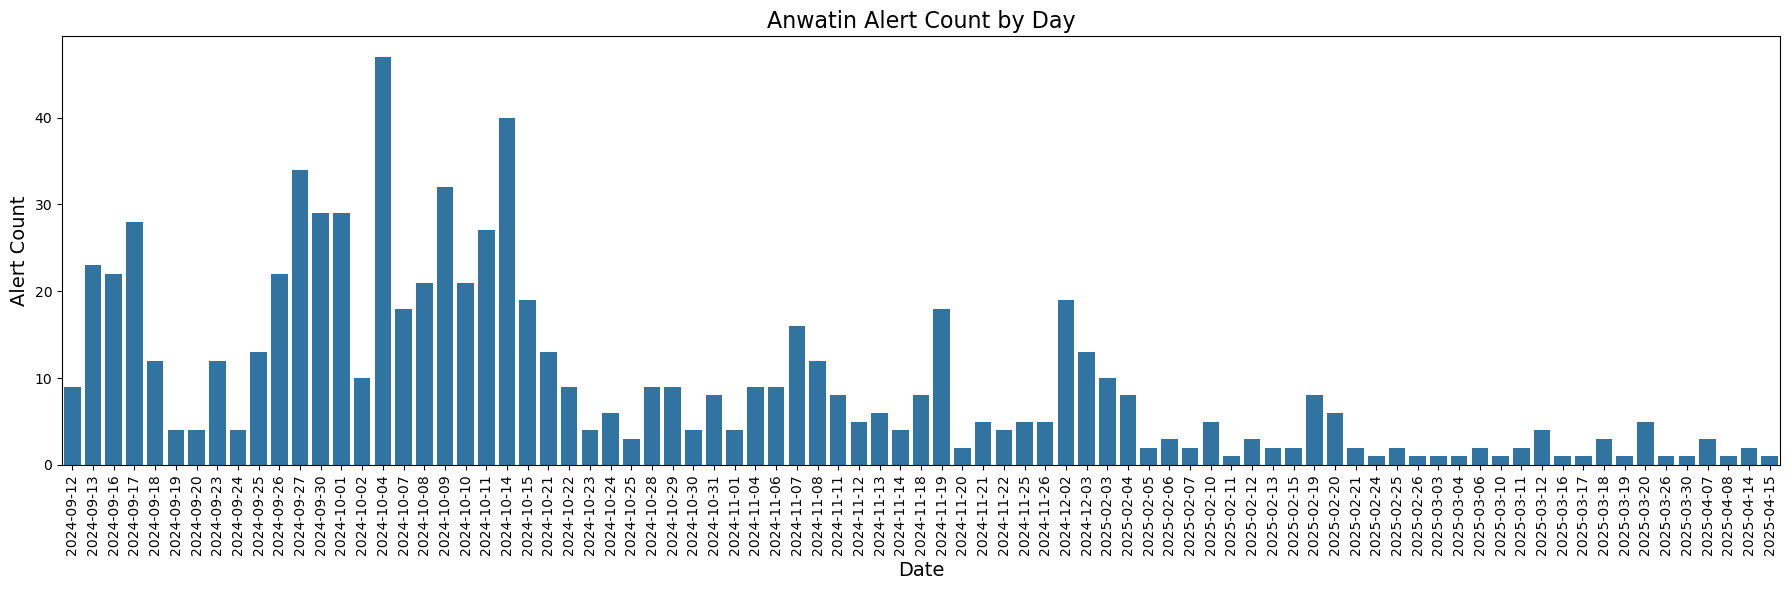

In [75]:
alert_count_by_day(anwatin_df)

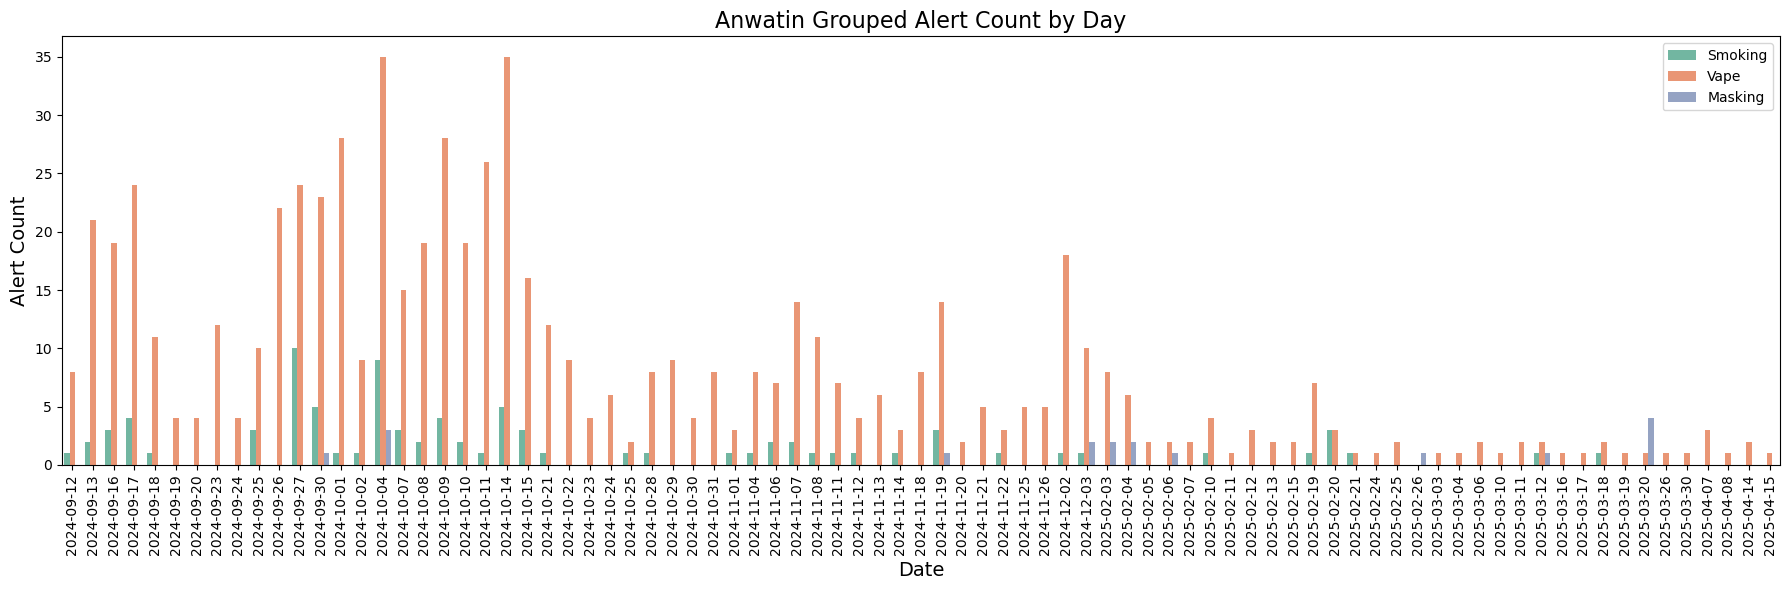

In [76]:
grouped_alert_count_by_day(anwatin_df, 'Type')

In [77]:
# Calculate the per month average of alerts
anwatin_monthly_counts, anwatin_monthly_dayavg = alert_count_by_month(anwatin_df)
anwatin_monthly = pd.DataFrame({'monthly_counts': anwatin_monthly_counts, 'avg_alerts_per_day': anwatin_monthly_dayavg})
anwatin_monthly.index = anwatin_monthly.index.strftime('%Y-%m')
anwatin_monthly

/var/folders/yt/xv1c41h15flg31_2xgl1rnj00000gn/T/ipykernel_34867/955996457.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = date_count.resample('M').sum()


,monthly_counts,avg_alerts_per_day
Date,,
2024-09,216,7.200000
2024-10,329,10.612903
2024-11,120,4.000000
2024-12,32,1.032258
2025-01,0,0.000000
2025-02,58,2.071429
2025-03,24,0.774194
2025-04,7,0.233333


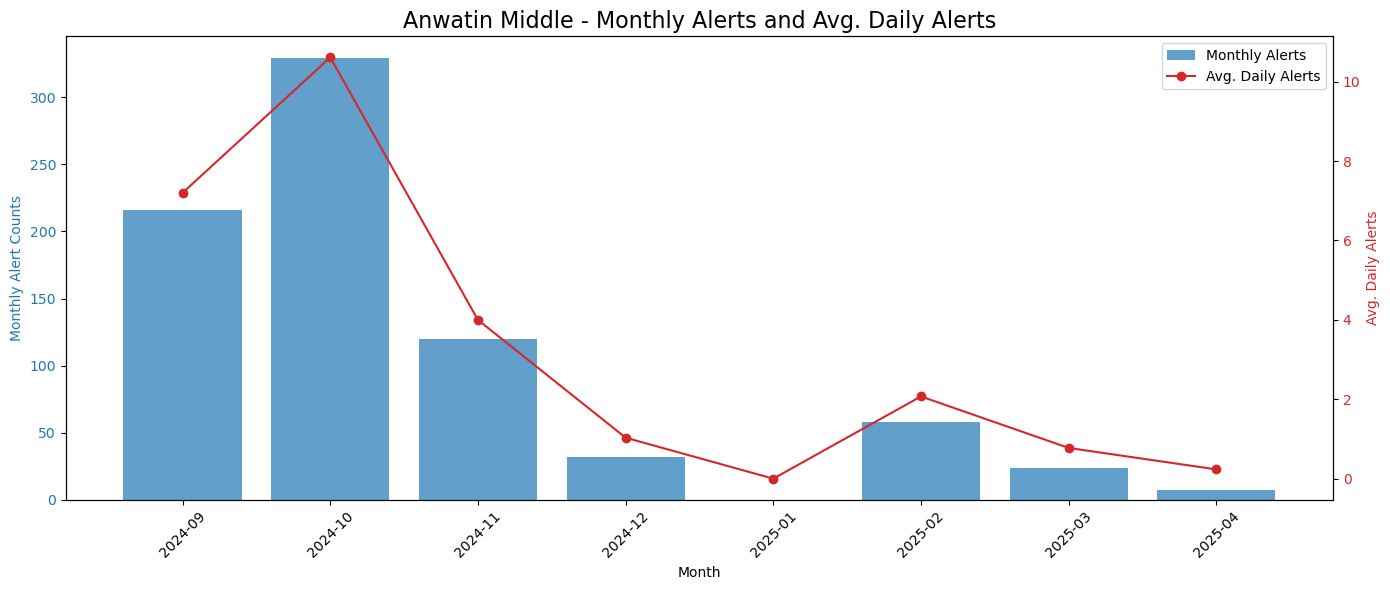

In [78]:
# Graphy anwatin_monthly
plot_monthly_data(anwatin_monthly, 'Anwatin Middle')

### Camden (Henry) High
4320 Newton Ave N, Minneapolis MN 55412

1. First alert: Sep 3, 2024 ; Last alert: Apr 15, 2025

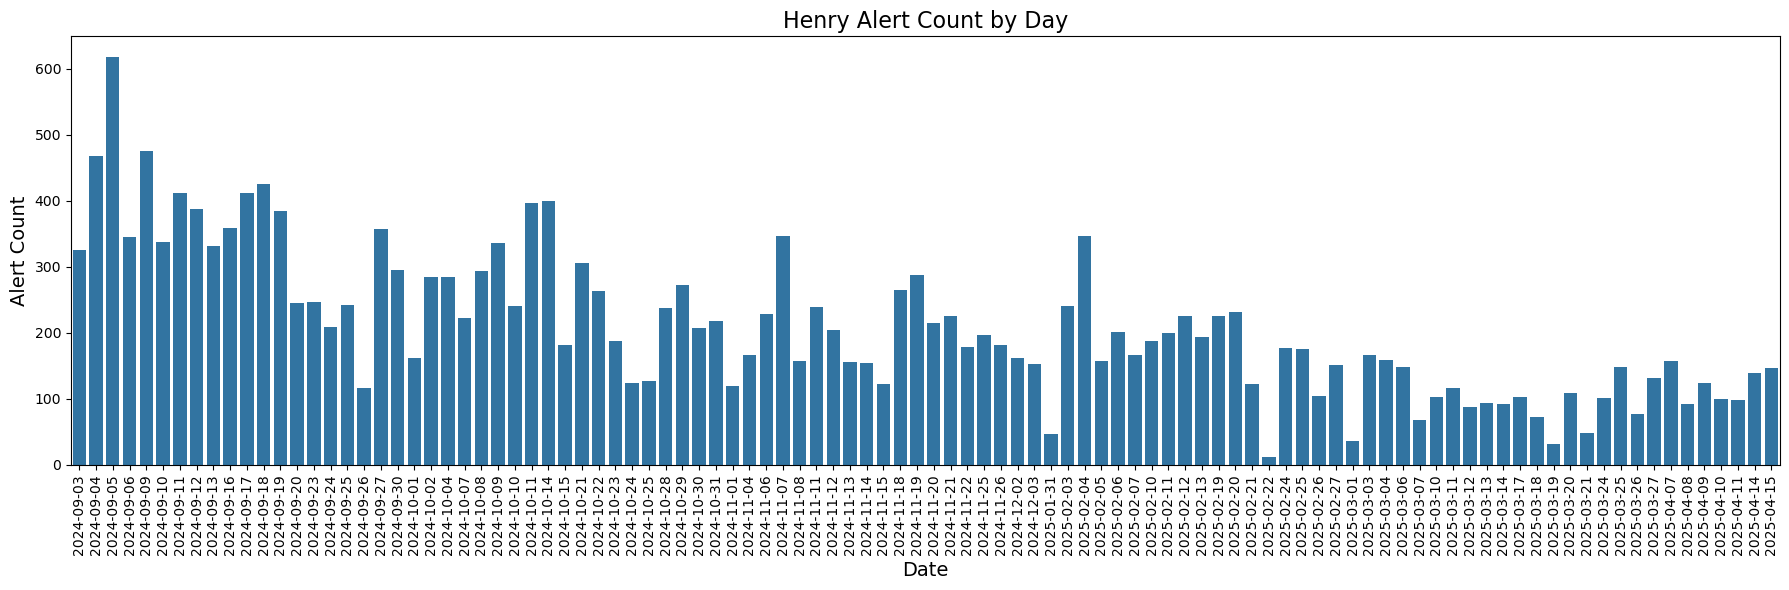

In [79]:
alert_count_by_day(camden_df)

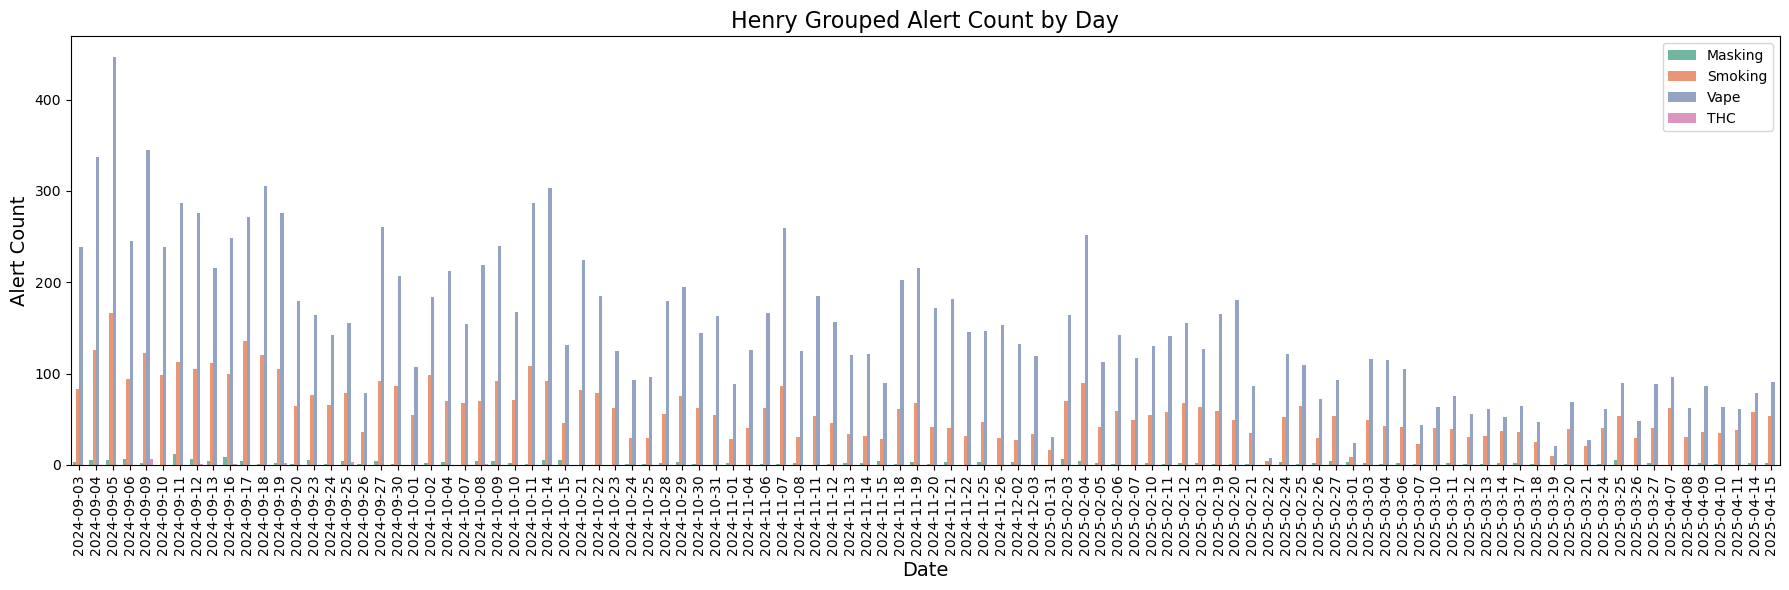

In [80]:
grouped_alert_count_by_day(camden_df, 'Type')

In [81]:
# Calculate the per month average of alerts
camden_monthly_counts, camden_monthly_dayavg = alert_count_by_month(camden_df)
camden_monthly = pd.DataFrame({'monthly_counts': camden_monthly_counts, 'avg_alerts_per_day': camden_monthly_dayavg})
camden_monthly.index = camden_monthly.index.strftime('%Y-%m')
camden_monthly

/var/folders/yt/xv1c41h15flg31_2xgl1rnj00000gn/T/ipykernel_34867/955996457.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = date_count.resample('M').sum()


,monthly_counts,avg_alerts_per_day
Date,,
2024-09,6991,233.033333
2024-10,4746,153.096774
2024-11,3445,114.833333
2024-12,315,10.161290
2025-01,47,1.516129
2025-02,3115,111.250000
2025-03,1896,61.161290
2025-04,860,28.666667


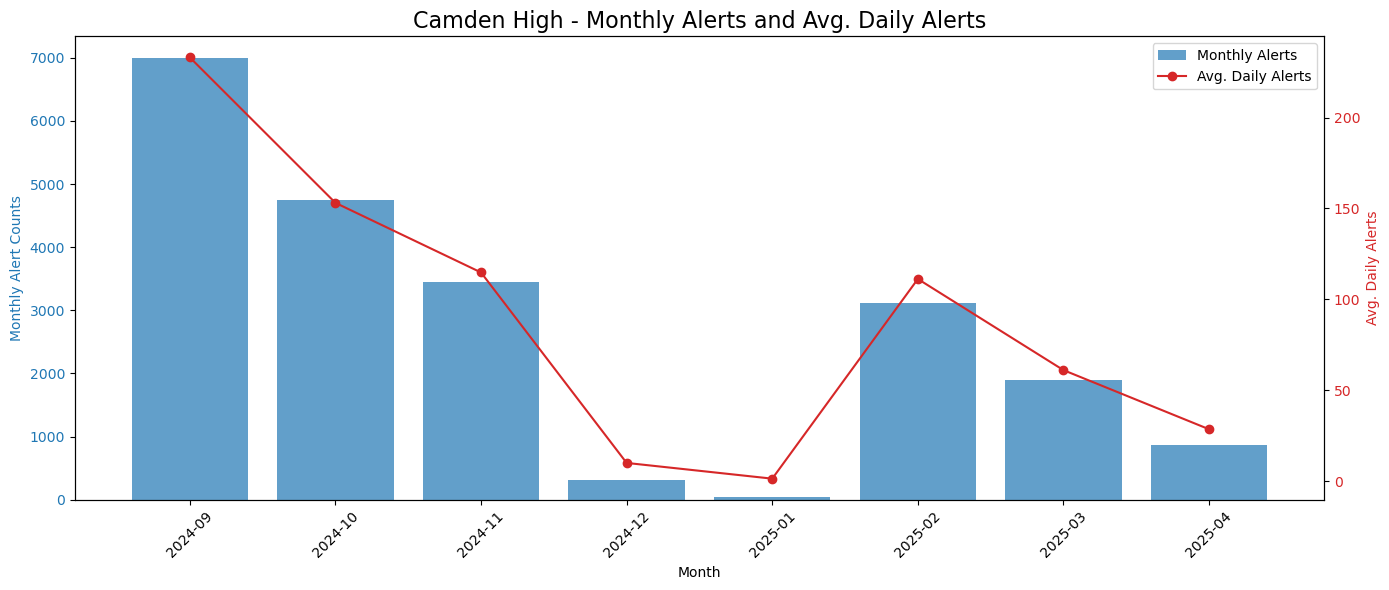

In [82]:
# Graph camden_monthly
plot_monthly_data(camden_monthly, 'Camden High')

### Roosevelt

1. First alert: Sep 11, 2024 ; Last alert: Apr 16, 2025

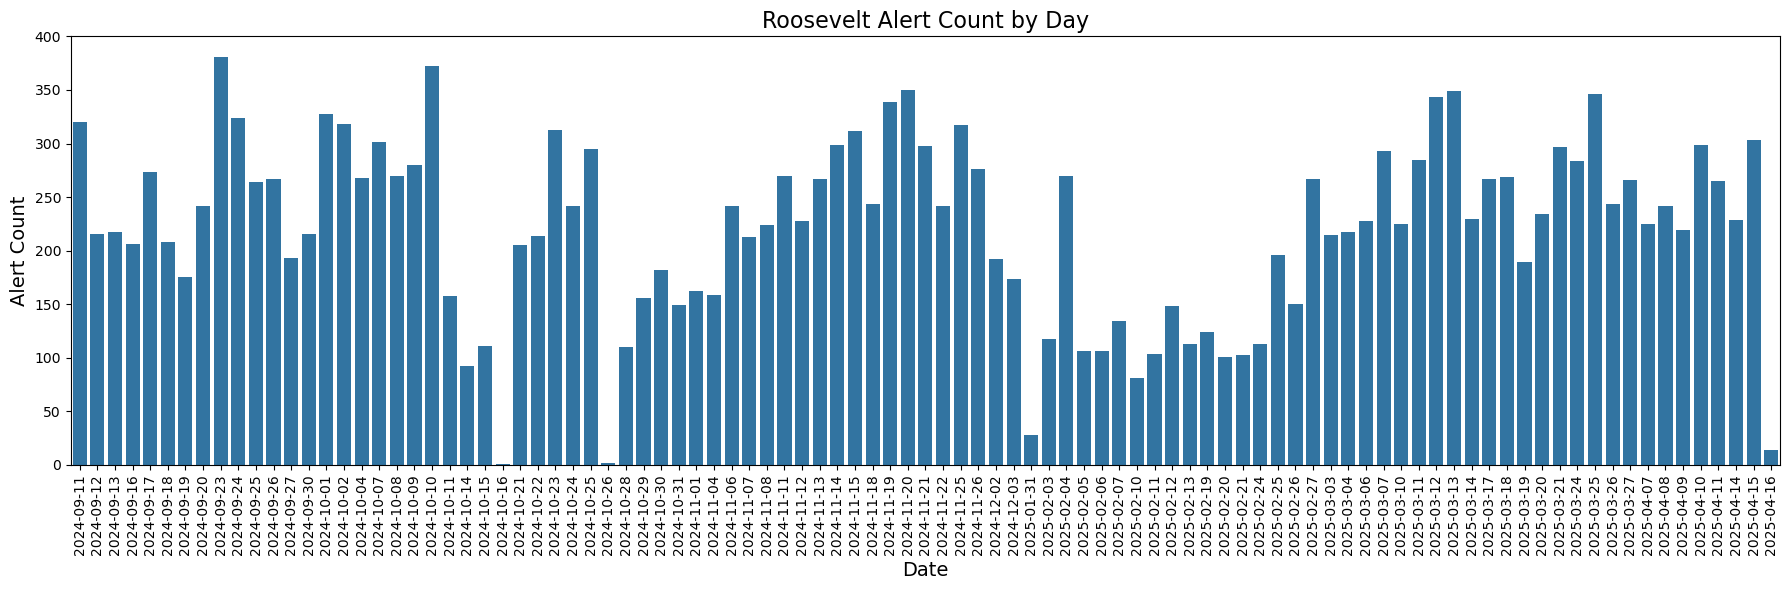

In [83]:
alert_count_by_day(roosevelt_df)

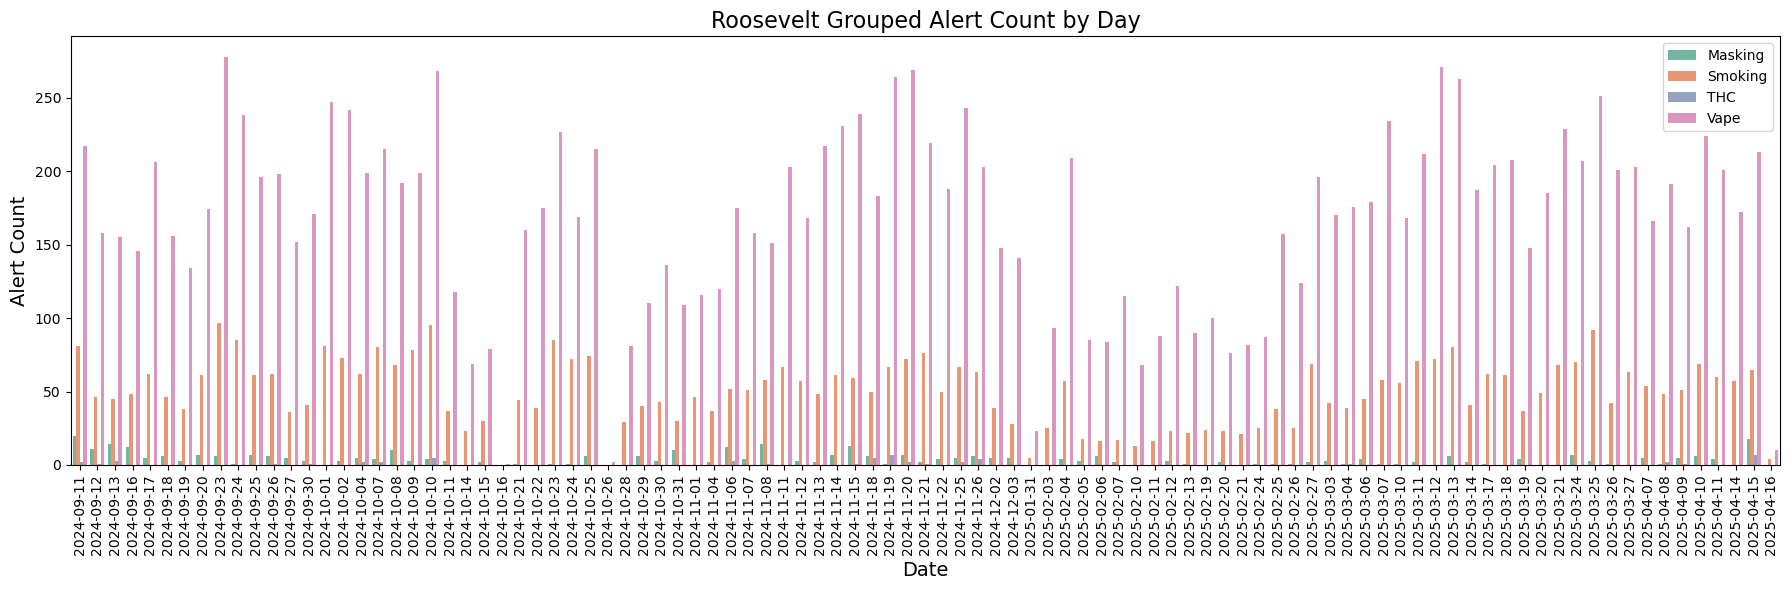

In [84]:
grouped_alert_count_by_day(roosevelt_df, 'Type')

In [85]:
# Calculate the per month average of alerts
roosevelt_monthly_counts, roosevelt_monthly_dayavg = alert_count_by_month(roosevelt_df)
roosevelt_monthly = pd.DataFrame({'monthly_counts': roosevelt_monthly_counts, 'avg_alerts_per_day': roosevelt_monthly_dayavg})
roosevelt_monthly.index = roosevelt_monthly.index.strftime('%Y-%m')
roosevelt_monthly

/var/folders/yt/xv1c41h15flg31_2xgl1rnj00000gn/T/ipykernel_34867/955996457.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = date_count.resample('M').sum()


,monthly_counts,avg_alerts_per_day
Date,,
2024-09,3502,116.733333
2024-10,4367,140.870968
2024-11,4442,148.066667
2024-12,366,11.806452
2025-01,28,0.903226
2025-02,2234,79.785714
2025-03,4781,154.225806
2025-04,1796,59.866667


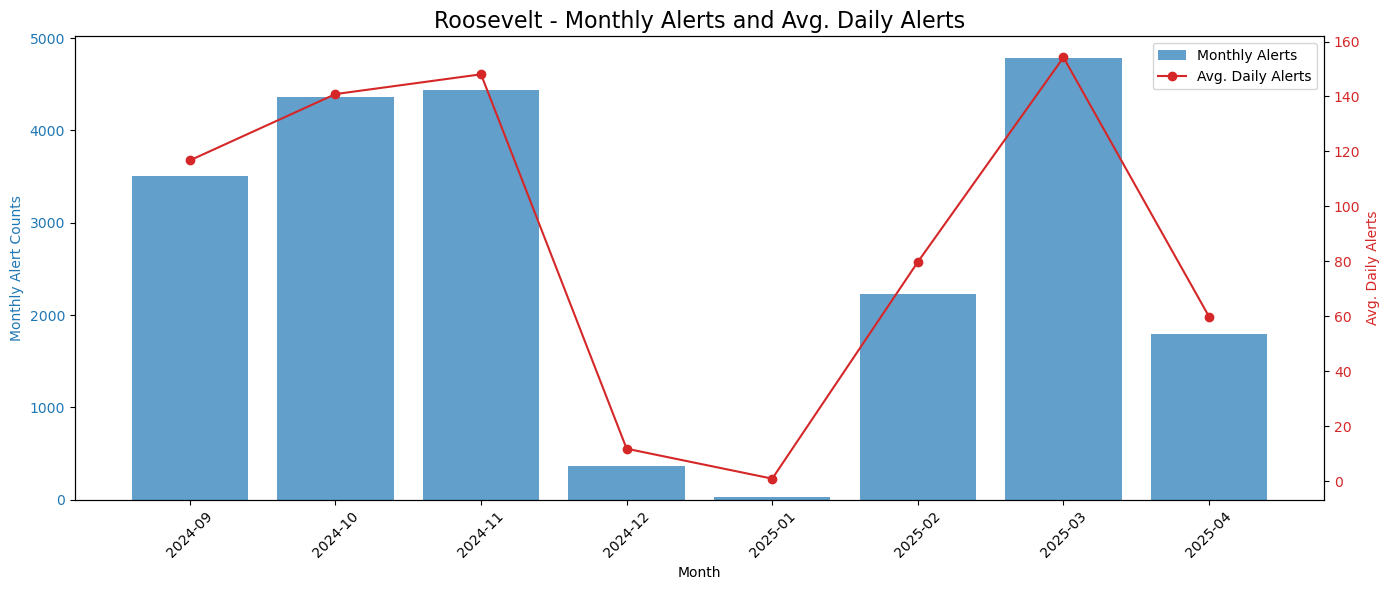

In [86]:
# Graph roosevelt_monthly
plot_monthly_data(roosevelt_monthly, 'Roosevelt')